In [8]:
# Recommended updated classes list to be used in cell rgkv3L4-X94M
updated_classes = ['eosinophil', 'lymphocyte', 'monocyte', 'neutrophil', 'RBC', 'WBC', 'Platelets']
print(f"Please update the 'classes' variable in cell rgkv3L4-X94M to: {updated_classes}")

# You can also uncomment the line below to verify the contents of 'blood_cells' after the fix:
# !ls -R blood_cells

Please update the 'classes' variable in cell rgkv3L4-X94M to: ['eosinophil', 'lymphocyte', 'monocyte', 'neutrophil', 'RBC', 'WBC', 'Platelets']


In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Download the BCCD Dataset
!wget -q https://github.com/Shenggan/BCCD_Dataset/archive/refs/heads/master.zip -O bccd_dataset.zip

# Unzip the dataset
!unzip -q bccd_dataset.zip

# Remove the zip file to clean up
!rm bccd_dataset.zip

print("BCCD Dataset downloaded and extracted successfully.")

BCCD Dataset downloaded and extracted successfully.


In [11]:
import os
import shutil
import xml.etree.ElementTree as ET

# Define paths using kernel state variables and typical dataset structure
# The dataset typically unzips to 'BCCD_Dataset-master'
# And the images/annotations are under 'BCCD_Dataset-master/BCCD'
base_data_path = 'BCCD_Dataset-master/BCCD'
img_source_path = os.path.join(base_data_path, 'JPEGImages')
annotation_path = os.path.join(base_data_path, 'Annotations')
output_dataset_path = 'blood_cells' # This corresponds to out_path from kernel state

# Classes from kernel state
classes = ['eosinophil', 'lymphocyte', 'monocyte', 'neutrophil', 'RBC', 'WBC', 'Platelets']

# Create class subdirectories in the output path if they don't exist
for cls_name in classes:
    os.makedirs(os.path.join(output_dataset_path, cls_name), exist_ok=True)

# Process XML annotations and copy images to respective class folders
print(f"Organizing images into '{output_dataset_path}'...")

for xml_file in os.listdir(annotation_path):
    if xml_file.endswith('.xml'):
        tree = ET.parse(os.path.join(annotation_path, xml_file))
        root = tree.getroot()

        # Get the image filename
        filename = root.find('filename').text
        source_image_filepath = os.path.join(img_source_path, filename)

        # Iterate through objects (blood cells) in the annotation
        for obj in root.findall('object'):
            class_name = obj.find('name').text
            if class_name in classes:
                destination_dir = os.path.join(output_dataset_path, class_name)
                destination_image_filepath = os.path.join(destination_dir, filename)

                # Copy the image if it exists and hasn't been copied for this class yet
                # (An image might have multiple annotated cells, but it belongs to one class based on the overall annotation)
                # To avoid multiple copies of the same image if it has multiple cells of the same type,
                # we only copy it once per class type encountered in its annotations.
                if os.path.exists(source_image_filepath) and not os.path.exists(destination_image_filepath):
                    shutil.copy(source_image_filepath, destination_dir)
            else:
                print(f"Warning: Unknown class '{class_name}' found in {xml_file}")

print("Image organization complete. You can now re-run the dataset loading cell.")

Organizing images into 'blood_cells'...
Image organization complete. You can now re-run the dataset loading cell.


In [12]:
!ls BCCD_Dataset-master

BCCD	 example.jpg  LICENSE  README.md  test.csv
dataset  export.py    plot.py  scripts


In [6]:
!ls BCCD_Dataset-master/BCCD

Annotations  ImageSets	JPEGImages


In [13]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    "blood_cells",
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "blood_cells",
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 908 files belonging to 7 classes.
Using 727 files for training.
Found 908 files belonging to 7 classes.
Using 181 files for validation.


In [14]:
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    "BCCD_Dataset-master/BCCD",
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "BCCD_Dataset-master/BCCD",
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 364 files belonging to 3 classes.
Using 292 files for training.
Found 364 files belonging to 3 classes.
Using 72 files for validation.


In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [16]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224,224,3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False  # Freeze base model

# Dynamically determine the number of classes from the pre-defined 'classes' list
# The 'train_ds' object (after .cache().shuffle().prefetch()) does not retain 'class_names'
num_classes = len(classes) # Use the global 'classes' list
print(f"Detected {num_classes} classes: {classes}") # Print the global 'classes' list

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax') # Use num_classes here
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Detected 7 classes: ['eosinophil', 'lymphocyte', 'monocyte', 'neutrophil', 'RBC', 'WBC', 'Platelets']


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,855 (9.24 MB)

 Trainable params: 164,871 (644.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [17]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

# Save the trained model
model.save('HematoVision_Model.h5')

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.6501 - loss: 1.3917 - val_accuracy: 1.0000 - val_loss: 1.3729e-05
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 1.0000 - loss: 6.4097e-06 - val_accuracy: 1.0000 - val_loss: 1.7550e-07
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 1.0000 - loss: 9.5687e-08 - val_accuracy: 1.0000 - val_loss: 9.9341e-09
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 1.0000 - loss: 8.7884e-09 - val_accuracy: 1.0000 - val_loss: 4.9671e-09
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 1.0000 - loss: 4.8953e-09 - val_accuracy: 1.0000 - val_loss: 3.3114e-09
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 1.0000 - loss: 7.2993e-09 - val_accuracy: 1.0000 - val_loss: 1.6557e-09
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 1.0000 - loss: 3.8902e-09 - val_accuracy: 1.0000 - val_loss: 1.6557e-09
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 1.00

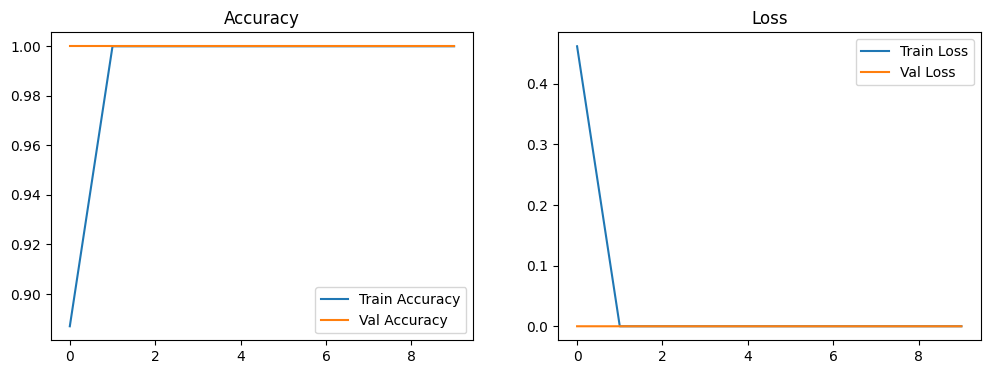

In [18]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.show()

In [19]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Load the saved model
model = tf.keras.models.load_model("HematoVision_Model.h5")

In [20]:
class_names = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']

In [21]:
from google.colab import files

uploaded = files.upload()

Saving BloodImage_00043.jpg to BloodImage_00043 (1).jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


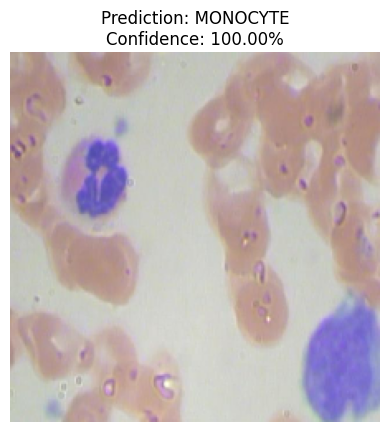

In [22]:
from tensorflow.keras.preprocessing import image

img_path = list(uploaded.keys())[0]

img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0

predictions = model.predict(img_array)
predicted_class = class_names[np.argmax(predictions)]
confidence = np.max(predictions) * 100

plt.imshow(img)
plt.axis('off')
plt.title(f"Prediction: {predicted_class}\nConfidence: {confidence:.2f}%")
plt.show()